In [1]:
# %tensorflow_version 2.x
# %load_ext tensorboard
import datetime
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

In [2]:
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 16
CLASSES = {
    0:'patrik',
    1: "spongebob",
    2: "squidward",
}

### Load dataset

In [3]:
dataset_path = './dataset/'
if not os.path.isdir(dataset_path):
    !unzip -q dataset.zip

In [4]:
image_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1/255.,
    validation_split=0.2
)


train_dataset = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=dataset_path,
    shuffle=True,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=dataset_path,
    shuffle=True,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
    subset="validation",
    class_mode='categorical'
)

Found 644 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


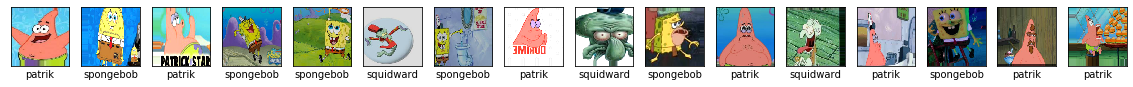

In [5]:
# visualization
classes = {
    0:'patrik',
    1: "spongebob",
    2: "squidward",
}

# show examples
_, axes = plt.subplots(nrows=1, ncols=BATCH_SIZE, figsize=(20, 20))
plt.setp(axes, xticks=[], yticks=[])

x, y = train_dataset[0]
for id in range(BATCH_SIZE):
    image, label = x[id], y[id]
    arr_ = np.squeeze(image)
    axes[id].imshow(image)
    index = tf.math.argmax(label, output_type=tf.int32, axis=0)
    axes[id].set_xlabel(CLASSES[index.numpy()])
plt.show()

### Load model

In [6]:
def make_extractor(img_shape, model=None, dropout_rate=0.25, trainable=False):
    if model is None:
        extractor = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet")
    else:
        extractor = model(include_top=False, weights="imagenet")
    for layer in extractor.layers:
        layer.trainable = trainable

    gap = tf.keras.layers.GlobalAveragePooling2D()
    dropout = tf.keras.layers.Dropout(dropout_rate)

    input = tf.keras.layers.Input(img_shape)
    x = extractor(input)
    x = dropout(x)
    x = gap(x)

    return tf.keras.Model(input, x)


def make_classifier(n_classes, img_shape, model=None,
                    units=64, dropout_rate=0.25, trainable=False):
    extractor = make_extractor(
        img_shape, model, dropout_rate=dropout_rate, trainable=trainable
    )
    dropout = tf.keras.layers.Dropout(dropout_rate)
    dense_1 = tf.keras.layers.Dense(units, activation='relu')
    dense_2 = tf.keras.layers.Dense(units, activation='relu')
    classifier = tf.keras.layers.Dense(n_classes, activation='softmax')

    input = tf.keras.layers.Input(img_shape)
    x = extractor(input)
    x = classifier(dropout(dense_2(dropout(dense_1(dropout(x))))))

    return tf.keras.Model(input, x)

In [7]:
classifier = make_classifier(3, IMG_SHAPE, units=BATCH_SIZE)
classifier.build([None] + list(IMG_SHAPE))
classifier.summary()
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
classifier.compile(optimizer, loss=loss, metrics=[metrics])

/home/kuskov/anaconda3/envs/cv_dl_tasks/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 1280)         2257984     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             multiple             0           model[1][0]                      
                                                                 dense[0][0]                      
                                                                 dense_1[0][0]                    
____________________________________________________________________________________________

In [8]:
#TSNE

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from numpy.linalg import norm


def make_tsne_plot(vectors, labels):
    pca_dimension = 100
    if vectors.shape[1] <= pca_dimension * 2:
        pca_vectors = vectors
    else:
        pca = PCA(pca_dimension)
        pca.fit(vectors)
        pca_vectors = pca.transform(vectors)

    tsne_results = TSNE(n_components=2,
                        verbose=1,
                        metric='euclidean').fit_transform(pca_vectors)

    cmap = plt.cm.get_cmap('coolwarm')
    plt.figure(figsize=(10, 8), dpi=80)
    scatter = plt.scatter(tsne_results[:,0],
                          tsne_results[:,1],
                          c=labels,
                          cmap=cmap)
    plt.colorbar(scatter)
    plt.show()

def make_tsne_plot_from_vectors(vectors, labels):
    tsne_results = TSNE(n_components=2,
                      verbose=1,
                      metric='euclidean').fit_transform(vectors)

    cmap = plt.cm.get_cmap('coolwarm')
    plt.figure(figsize=(10, 8), dpi=80)
    scatter = plt.scatter(tsne_results[:, 0],
                        tsne_results[:, 1],
                        c=labels,
                        cmap=cmap)
    plt.colorbar(scatter)
    plt.show()

In [9]:
labels = []
images = []
for idx, (im, l) in enumerate(test_dataset):
    if idx > len(test_dataset):
        break
    else:
        images.extend([i for i in im])
        labels.extend(np.argmax(l, axis=1).tolist())

images = np.array(images)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 175 samples in 0.001s...
[t-SNE] Computed neighbors for 175 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 175 / 175
[t-SNE] Mean sigma: 0.311562
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.237595
[t-SNE] KL divergence after 1000 iterations: 0.472117


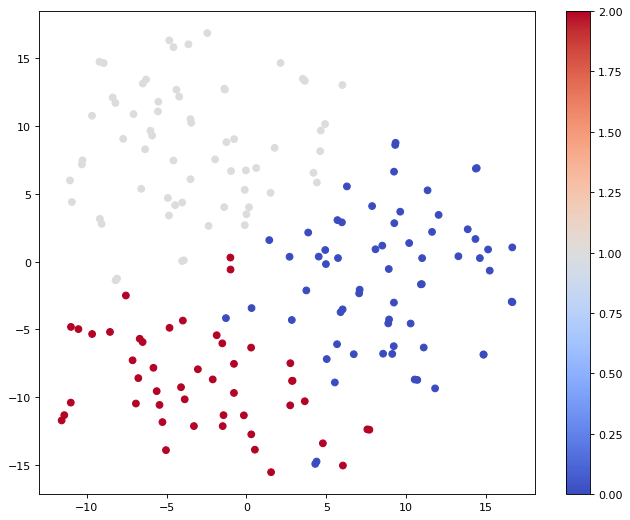

In [10]:
def normalize_vectors(feature_vectors):
  return feature_vectors / np.expand_dims(norm(feature_vectors, axis=1), axis=-1)

extractor = tf.keras.Model(classifier.layers[1].input, classifier.layers[1].output)
feature_vectors = extractor.predict(images)
feature_vectors = normalize_vectors(feature_vectors)
make_tsne_plot(feature_vectors, labels)

Train last Layers

In [11]:
def plot_history(history):
    # Plot training & validation accuracy values
    print(plot_history)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Test loss'], loc='upper left')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()

In [12]:
EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=5,
                                               restore_best_weights=True)
logdir = os.path.join("logs/classifier",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [early_stopping, tensorboard]

history = classifier.fit(train_dataset,
                         validation_data=test_dataset,
                         epochs=EPOCHS,
                         callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 41 steps, validate for 10 steps
Epoch 1/100
41/41 [==============================] - 13s 307ms/step - loss: 1.0522 - categorical_accuracy: 0.4503 - val_loss: 0.8780 - val_categorical_accuracy: 0.6226

<function plot_history at 0x7f197473c560>


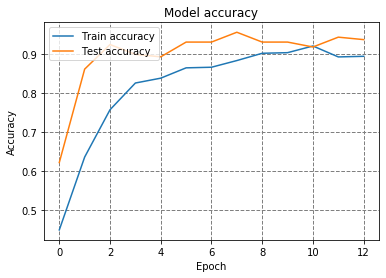

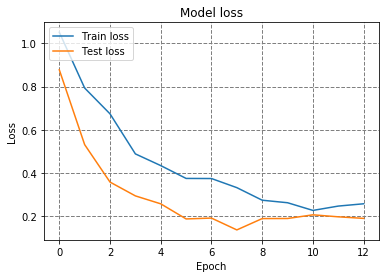

In [13]:
plot_history(history)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 175 samples in 0.000s...
[t-SNE] Computed neighbors for 175 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 175 / 175
[t-SNE] Mean sigma: 0.134734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.808846
[t-SNE] KL divergence after 900 iterations: 0.134777


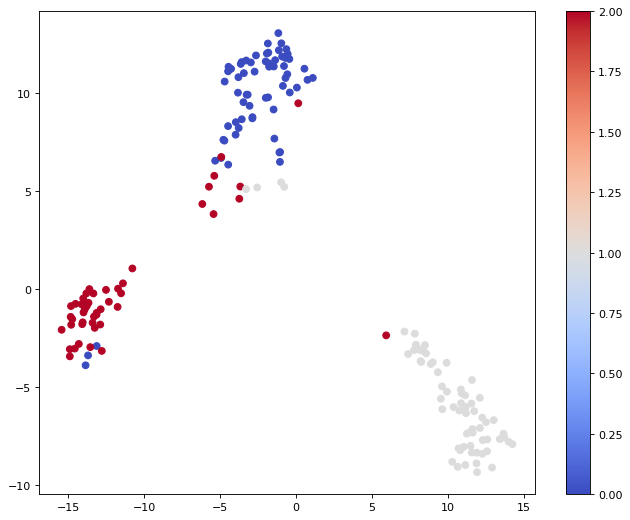

In [14]:
model_last_dense_layer = tf.keras.Model(classifier.input, 
                                     classifier.layers[-2].output)
feature_vectors_trained = normalize_vectors(
    model_last_dense_layer.predict(images))
make_tsne_plot(feature_vectors_trained, labels)

Checkpoint

In [15]:
classifier.save("model_last_dense_layers.h5")

In [16]:
def make_backbone_trainable(classifier):
  trainable_backbone = make_classifier(3, IMG_SHAPE, units=BATCH_SIZE, trainable=True)
  trainable_backbone.set_weights(classifier.get_weights())
  return trainable_backbone

In [17]:
trainable_backbone = make_backbone_trainable(classifier)

/home/kuskov/anaconda3/envs/cv_dl_tasks/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [18]:
trainable_backbone.build([None] + list(IMG_SHAPE))
trainable_backbone.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
metrics = tf.keras.metrics.CategoricalAccuracy()
trainable_backbone.compile(optimizer,
                           loss='categorical_crossentropy', 
                           metrics=[metrics])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1280)         2257984     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             multiple             0           model_4[1][0]                    
                                                                 dense_3[0][0]                    
                                                                 dense_4[0][0]                    
____________________________________________________________________________________________

In [19]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=2,
                                               restore_best_weights=True)

callbacks = [early_stopping]

b_history = trainable_backbone.fit(train_dataset,
                                 validation_data=test_dataset,
                                 epochs=EPOCHS,
                                 callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 41 steps, validate for 10 steps
Epoch 1/100
41/41 [==============================] - 15s 360ms/step - loss: 0.2665 - categorical_accuracy: 0.8944 - val_loss: 0.1674 - val_categorical_accuracy: 0.9434

<function plot_history at 0x7f197473c560>


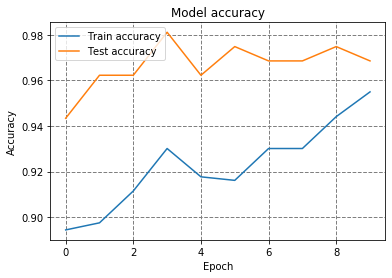

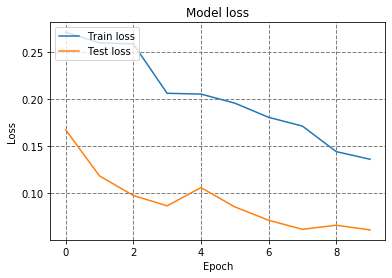

In [20]:
plot_history(b_history)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 175 samples in 0.001s...
[t-SNE] Computed neighbors for 175 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 175 / 175
[t-SNE] Mean sigma: 0.329542
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.087708
[t-SNE] KL divergence after 1000 iterations: 0.449734


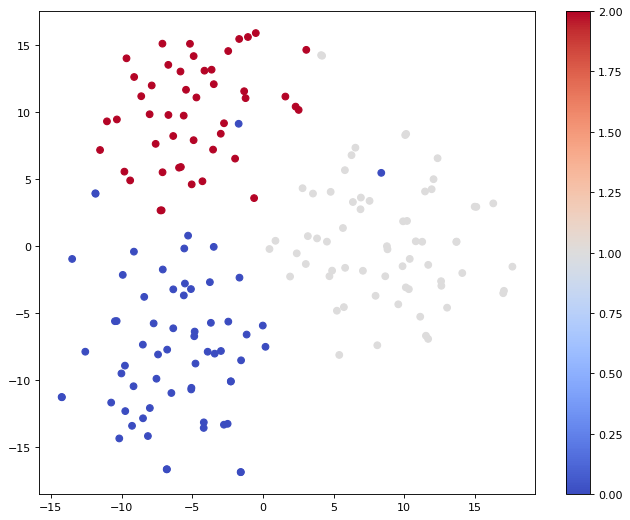

In [21]:
modified_extractor = tf.keras.Model(trainable_backbone.layers[1].input, 
                                 trainable_backbone.layers[1].output)
feature_vectors = modified_extractor.predict(images)
feature_vectors = normalize_vectors(feature_vectors)
make_tsne_plot(feature_vectors, labels)

Checkpoint

In [22]:
trainable_backbone.save("./model_full_layers.h5")
# model_loaded = tf.keras.models.load_model("./model_full_layers.h5")